In [2]:
#!/usr/bin/env python3
import sys
srcdir = "/project/mchaisso_100/cmb-16/tsungyul/work/vntr/danbing-tk/script/"
sys.path.insert(0, srcdir)

In [3]:
import numpy as np
import pandas as pd
import vntrutils as vu
import utils
# import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# %load_ext autoreload
# %autoreload 2

In [4]:
from collections import defaultdict
import pickle
# import networkx as nx
# import pygraphviz
# import collections
import gc
import glob
# import warnings
import statsmodels.api as sm
# from statsmodels.stats.multitest import fdrcorrection as fdr
# from scipy import stats
import gzip
# from sklearn.decomposition import PCA
# from scipy.stats import chi2
# import re
# import json

In [5]:
matplotlib.rc('font', size=7)
matplotlib.rc('axes', titlesize=7)
matplotlib.rc('xtick', labelsize=5)
matplotlib.rc('ytick', labelsize=5)
%load_ext autoreload
%autoreload 2

In [6]:
def report_ground_truth_novel_kmers(fn):
    ch_s = [".", "=", "*"] # characters not interested
    reads = []
    ops = []
    opis = []
    ks = 21
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            for chi, ch in enumerate(vs[4]):
                if ch not in ch_s:
                    print(vs[3])
                    print(f"{' '*(ks-1)}{vs[4]}")
                    reads.append(vs[3])
                    ops.append(vs[4])
                    opis.append(chi)
            for chi, ch in enumerate(vs[7]):
                if ch not in ch_s:
                    print(vs[6])
                    print(f"{' '*(ks-1)}{vs[7]}")
                    reads.append(vs[6])
                    ops.append(vs[7])
                    opis.append(chi)
    kmers = defaultdict(int)
    nr = 0
    for read, op, opi in zip(reads, ops, opis):
        RL = len(read)
        if op[opi-1] == "." or op[opi+1] == ".": continue # XXX boundary problem
        nr += 1
        # cre = f"{read[:opi+ks-1]}{op[opi]}{read[opi+ks:]}" # corrected read
        for si in range(opi, min(RL-ks,opi+ks-1)+1):
            assert si+ks<=RL
            kmn = read[si:si+ks]
            km = vu.string2CaKmer(kmn)
            kmers[km] += 1
    print (f"{nr} candidate reads")
    print(f"{len(kmers)} novel kmers")
    for km, ct in kmers.items():
        kmn = vu.decodeNumericString(km, ks)
        print(f"{km}\t{ct}\t{kmn}")
    return kmers
                    
gt_nkmers = report_ground_truth_novel_kmers("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.aln.gz") # ground truth novel kmers

AGGACGCCCGAGAAGACAGGCGGTGGCAGAGATCTTCAGAGAGAGAGATGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACACCTGAGAAGACAGG
                    =======G==========================================================================================================================
TCTGAAGATCTCCACCACCGCCTGTCTTCTCAGGTGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCATCTCTCTCTCTGAAGATCTCTGCCACCG
                    ==========================================================================================================================C=======
TCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAGAAGACAGGCGGTGGCAGAGATCTTCAGAGAGAGAGATGCCCGAGAAGACAGGCGGTGGCGGAGATCTTCAGAGAGAGGACGCCCGAG
                    ==========================================================G=======================================================================
ACCGCCTGTCTTCTCGGGCGTCCTCTCTCTGAAGATCTCCGCCACCGCCTGTCTTCTCGGGCATCTCTCTCTCTGAAGATCTCTGCCACCGCCT

In [7]:
ks = 21

class nvk_t:
    def __init__(self):
        self.d = defaultdict(int) # novel kmers
        self.n = 0 # num of candidate reads
        
def _accum_novel_kmers(nvk, read, ops, indel=False):
    ni_s = [".", "=", "*","N"] # characters not interested
    d_s = ["0","1","2","3"]
    m_s = ["A","C","G","T"]
    rl = len(read)
    dti = 0
    chis = set()
    for chi, ch in enumerate(ops):
        kset = set(range(chi+dti,min(chi+dti+ks,rl)))
        if ch not in ni_s:
            km1set = set(range(chi+dti,min(chi+dti+ks-1,rl)))
            if ops[chi-1] != "=" or ops[chi+1] != "=":
                if ch in d_s:
                    chis -= km1set
                else:
                    chis -= kset
            else:
                if ch in m_s:
                    chis |= kset
                elif ch in d_s:
                    if indel:
                        chis |= km1set
                    dti -= 1
                elif ch == "I":
                    if indel:
                        chis |= kset
        elif ch == "*" or ch == ".":
            chis -= kset
    if chis:
        nvk.n += 1
        for chi in chis:
            nvk.d[vu.string2CaKmer(read[chi:chi+ks])] += 1

In [8]:
def eval_novel_kmers_v1(fn, th=-1, indel=False):
    nvk = nvk_t()
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            _accum_novel_kmers(nvk, vs[3], vs[4], indel=indel)
            _accum_novel_kmers(nvk, vs[6], vs[7], indel=indel)
    print (f"{nvk.n} candidate reads")
    
    vs = np.array(list(nvk.d.values()))
    utils.hist(vs[vs>th], dpi=300)
    mtp = defaultdict(int)
    for v in vs:
        mtp[v] += 1
    for k in sorted(mtp.keys()):
        print(k, mtp[k])
    print()
    
    nrep = 0
    maxn = 0
    ming = max(nvk.d.values())
    nbnoi = 0
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km in gt_nkmers:
            nrep += 1
            ming = min(ming, ct)
            print(f"{km}\t{ct}\t{kmn}")
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km not in gt_nkmers and ct >= ming:
            nbnoi += 1
            print(f"*{km}\t{ct}\t{kmn}")
            maxn = max(maxn, ct)

    ngt = len(gt_nkmers)
    nnoi = len(nvk.d) - nrep
    print(f"{nrep}/{ngt} ground truth novel kmers replicated, min replicated count = {ming}")
    print(f"{nnoi} noise kmers, {nbnoi} w/ ct >= {ming}, max count = {maxn}")

238 candidate reads


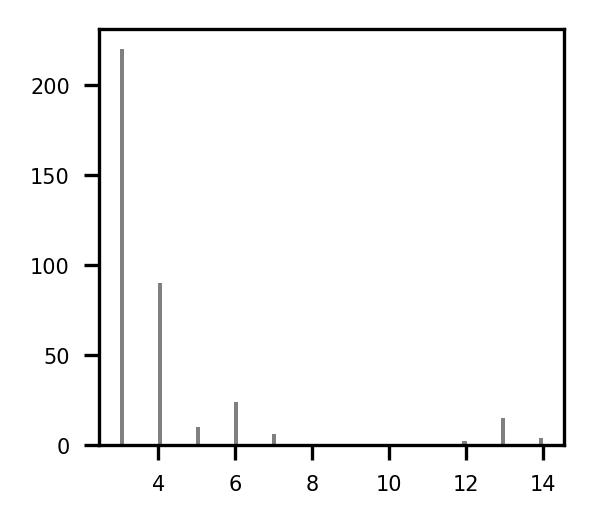

1 3084
2 654
3 220
4 90
5 10
6 24
7 6
12 2
13 15
14 4

2510642514056	13	GCAGAGATCTTCAGAGAGAGA
2052424523237	13	CTCTCTCTGAAGATCTCTGCC
3811651581844	13	TCTCTCTGAAGATCTCTGCCA
2052466794065	13	CTCTCTGAAGATCTCTGCCAC
2999104435336	13	GGTGGCAGAGATCTTCAGAGA
1849287736610	13	CGGTGGCAGAGATCTTCAGAG
2661345189704	13	GCGGTGGCAGAGATCTTCAGA
2063964459365	14	CTGAAGATCTCTGCCACCGCC
716089888244	14	AGGCGGTGGCAGAGATCTTCA
1278534099837	14	CAGGCGGTGGCAGAGATCTTC
152330066299	13	AAGATCTCTGCCACCGCCTGT
609320265197	14	AGATCTCTGCCACCGCCTGTC
569732909197	13	AGACAGGCGGTGGCAGAGATC
142433227299	13	AAGACAGGCGGTGGCAGAGAT
2234631562376	13	GAAGACAGGCGGTGGCAGAGA
558657890594	13	AGAAGACAGGCGGTGGCAGAG
2338687728200	13	GAGAAGACAGGCGGTGGCAGA
1684183559826	13	CGAGAAGACAGGCGGTGGCAG
1520557517732	13	CCGAGAAGACAGGCGGTGGCA
1246477034018	12	CAGAGATCTTCAGAGAGAGAG
587861624968	12	AGAGATCTTCAGAGAGAGAGA
21/21 ground truth novel kmers replicated, min replicated count = 12
4088 noise kmers, 0 w/ ct >= 12, max count = 0


In [9]:
# try on the easy errorenous case
eval_novel_kmers_v1("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.err.1bpindel.aln.gz", th=2)

274 candidate reads


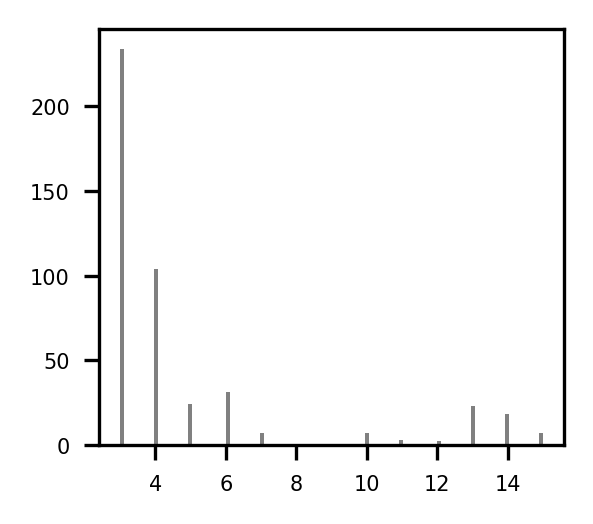

1 3229
2 664
3 234
4 104
5 24
6 31
7 7
10 7
11 3
12 2
13 23
14 18
15 7

2510642514056	13	GCAGAGATCTTCAGAGAGAGA
2052424523237	13	CTCTCTCTGAAGATCTCTGCC
3811651581844	13	TCTCTCTGAAGATCTCTGCCA
2052466794065	13	CTCTCTGAAGATCTCTGCCAC
2999104435336	13	GGTGGCAGAGATCTTCAGAGA
1849287736610	13	CGGTGGCAGAGATCTTCAGAG
2661345189704	13	GCGGTGGCAGAGATCTTCAGA
2063964459365	14	CTGAAGATCTCTGCCACCGCC
716089888244	14	AGGCGGTGGCAGAGATCTTCA
1278534099837	14	CAGGCGGTGGCAGAGATCTTC
152330066299	13	AAGATCTCTGCCACCGCCTGT
609320265197	14	AGATCTCTGCCACCGCCTGTC
569732909197	13	AGACAGGCGGTGGCAGAGATC
142433227299	13	AAGACAGGCGGTGGCAGAGAT
2234631562376	13	GAAGACAGGCGGTGGCAGAGA
558657890594	13	AGAAGACAGGCGGTGGCAGAG
2338687728200	13	GAGAAGACAGGCGGTGGCAGA
1684183559826	13	CGAGAAGACAGGCGGTGGCAG
1520557517732	13	CCGAGAAGACAGGCGGTGGCA
1246477034018	12	CAGAGATCTTCAGAGAGAGAG
587861624968	12	AGAGATCTTCAGAGAGAGAGA
*319600101597	14	ACAGGCGGCGGCGGAGATCTC
*1278400406388	14	CAGGCGGCGGCGGAGATCTCA
*715555114450	14	AGGCGGCGGCGGAGATCTCA

In [10]:
# try on the easy errorenous case
eval_novel_kmers_v1("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.err.1bpindel.aln.gz", th=2, indel=True)

In [11]:
def test():
    trkm = set()
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/input/loo_HG00171.175.tr.kmers") as f:
        for line in f:
            if line[0] == ">": continue
            vs = line.split()
            trkm.add(int(vs[0]))
    return trkm
trkm = test()

In [12]:
def _accum_novel_kmers_v2(nvk, trk, read, ops, indel=False):
    ni_s = [".", "=", "*","N"] # characters not interested
    d_s = ["0","1","2","3"]
    m_s = ["A","C","G","T"]
    rl = len(read)
    dti = 0
    chis = set()
    for chi, ch in enumerate(ops):
        kset = set(range(chi+dti,min(chi+dti+ks,rl)))
        if ch not in ni_s:
            km1set = set(range(chi+dti,min(chi+dti+ks-1,rl)))
            if ops[chi-1] != "=" or ops[chi+1] != "=":
                if ch in d_s:
                    chis -= km1set
                else:
                    chis -= kset
            else:
                if ch in m_s:
                    chis |= kset
                elif ch in d_s:
                    if indel:
                        chis |= km1set
                    dti -= 1
                elif ch == "I":
                    if indel:
                        chis |= kset
        elif ch == "*" or ch == ".":
            chis -= kset
    if chis:
        nvk.n += 1
        for chi in chis:
            km = vu.string2CaKmer(read[chi:chi+ks])
            if km not in trk:
                nvk.d[km] += 1
            
def eval_novel_kmers_v2(fn, th=-1, indel=False):
    nvk = nvk_t()
    with gzip.open(fn, 'rt') as f:
        for line in f:
            vs = line.split()
            _accum_novel_kmers_v2(nvk, trkm, vs[3], vs[4], indel=indel)
            _accum_novel_kmers_v2(nvk, trkm, vs[6], vs[7], indel=indel)
    print (f"{nvk.n} candidate reads")
    
    vs = np.array(list(nvk.d.values()))
    utils.hist(vs[vs>th], dpi=300)
    mtp = defaultdict(int)
    for v in vs:
        mtp[v] += 1
    for k in sorted(mtp.keys()):
        print(k, mtp[k])
    print()
    
    nrep = 0
    maxn = 0
    ming = max(nvk.d.values())
    nbnoi = 0
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km in gt_nkmers:
            nrep += 1
            ming = min(ming, ct)
            print(f"{km}\t{ct}\t{kmn}")
    for km, ct in nvk.d.items():
        kmn = vu.decodeNumericString(km, ks)
        if km not in gt_nkmers and ct >= ming:
            nbnoi += 1
            print(f"*{km}\t{ct}\t{kmn}")
            maxn = max(maxn, ct)

    ngt = len(gt_nkmers)
    nnoi = len(nvk.d) - nrep
    print(f"{nrep}/{ngt} ground truth novel kmers replicated, min replicated count = {ming}")
    print(f"{nnoi} noise kmers, {nbnoi} w/ ct >= {ming}, max count = {maxn}")
    
# this version checks overlap with trkmers

238 candidate reads


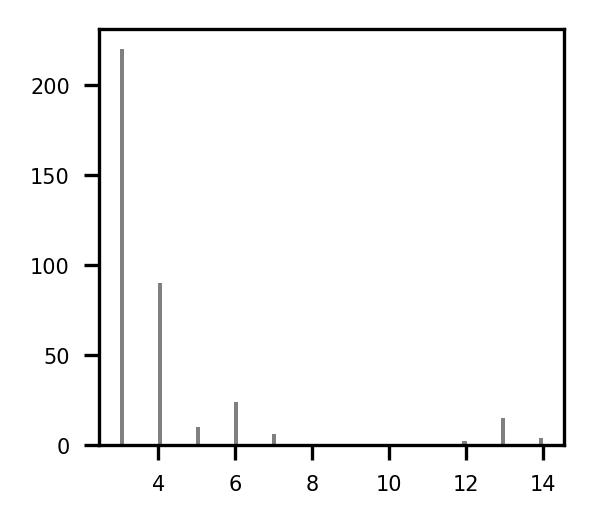

1 3047
2 643
3 220
4 90
5 10
6 24
7 6
12 2
13 15
14 4

2510642514056	13	GCAGAGATCTTCAGAGAGAGA
2052424523237	13	CTCTCTCTGAAGATCTCTGCC
3811651581844	13	TCTCTCTGAAGATCTCTGCCA
2052466794065	13	CTCTCTGAAGATCTCTGCCAC
2999104435336	13	GGTGGCAGAGATCTTCAGAGA
1849287736610	13	CGGTGGCAGAGATCTTCAGAG
2661345189704	13	GCGGTGGCAGAGATCTTCAGA
2063964459365	14	CTGAAGATCTCTGCCACCGCC
716089888244	14	AGGCGGTGGCAGAGATCTTCA
1278534099837	14	CAGGCGGTGGCAGAGATCTTC
152330066299	13	AAGATCTCTGCCACCGCCTGT
609320265197	14	AGATCTCTGCCACCGCCTGTC
569732909197	13	AGACAGGCGGTGGCAGAGATC
142433227299	13	AAGACAGGCGGTGGCAGAGAT
2234631562376	13	GAAGACAGGCGGTGGCAGAGA
558657890594	13	AGAAGACAGGCGGTGGCAGAG
2338687728200	13	GAGAAGACAGGCGGTGGCAGA
1684183559826	13	CGAGAAGACAGGCGGTGGCAG
1520557517732	13	CCGAGAAGACAGGCGGTGGCA
1246477034018	12	CAGAGATCTTCAGAGAGAGAG
587861624968	12	AGAGATCTTCAGAGAGAGAGA
21/21 ground truth novel kmers replicated, min replicated count = 12
4040 noise kmers, 0 w/ ct >= 12, max count = 0


In [13]:
# try on the easy errorenous case
eval_novel_kmers_v2("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.err.1bpindel.aln.gz", th=2, indel=False)

274 candidate reads


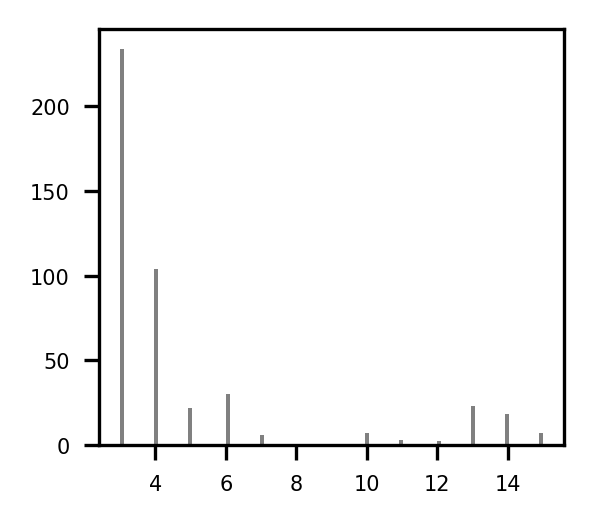

1 3192
2 653
3 234
4 104
5 22
6 30
7 6
10 7
11 3
12 2
13 23
14 18
15 7

2510642514056	13	GCAGAGATCTTCAGAGAGAGA
2052424523237	13	CTCTCTCTGAAGATCTCTGCC
3811651581844	13	TCTCTCTGAAGATCTCTGCCA
2052466794065	13	CTCTCTGAAGATCTCTGCCAC
2999104435336	13	GGTGGCAGAGATCTTCAGAGA
1849287736610	13	CGGTGGCAGAGATCTTCAGAG
2661345189704	13	GCGGTGGCAGAGATCTTCAGA
2063964459365	14	CTGAAGATCTCTGCCACCGCC
716089888244	14	AGGCGGTGGCAGAGATCTTCA
1278534099837	14	CAGGCGGTGGCAGAGATCTTC
152330066299	13	AAGATCTCTGCCACCGCCTGT
609320265197	14	AGATCTCTGCCACCGCCTGTC
569732909197	13	AGACAGGCGGTGGCAGAGATC
142433227299	13	AAGACAGGCGGTGGCAGAGAT
2234631562376	13	GAAGACAGGCGGTGGCAGAGA
558657890594	13	AGAAGACAGGCGGTGGCAGAG
2338687728200	13	GAGAAGACAGGCGGTGGCAGA
1684183559826	13	CGAGAAGACAGGCGGTGGCAG
1520557517732	13	CCGAGAAGACAGGCGGTGGCA
1246477034018	12	CAGAGATCTTCAGAGAGAGAG
587861624968	12	AGAGATCTTCAGAGAGAGAGA
*319600101597	14	ACAGGCGGCGGCGGAGATCTC
*1278400406388	14	CAGGCGGCGGCGGAGATCTCA
*715555114450	14	AGGCGGCGGCGGAGATCTCA

In [14]:
# try on the easy errorenous case
eval_novel_kmers_v2("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/rare_var/test/output/175.err.1bpindel.aln.gz", th=2, indel=True)